In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from harmony import harmonize
from anndata import AnnData
import anndata
from sklearn.utils import shuffle
import copy
import matplotlib.pyplot as plt
import xgboost as xgb
import anndata as ad
import importlib
import PlotConfusion as pc
importlib.reload(pc)
import PlotConfusion as pc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


# QC Filtering

In [3]:
adata = sc.read_h5ad('path/to/adatasP7b2_adata_raw.h5ad')

In [4]:
print(len(adata.obs))

55858


In [5]:
sc.pp.filter_cells(adata, min_genes=700)

filtered out 10617 cells that have less than 700 genes expressed


C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


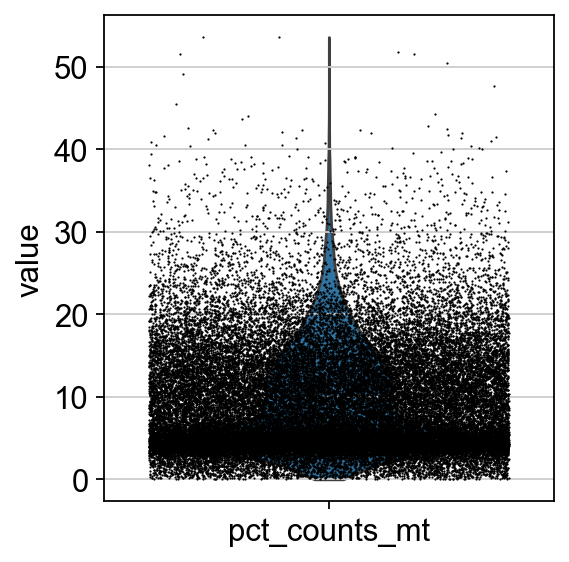

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


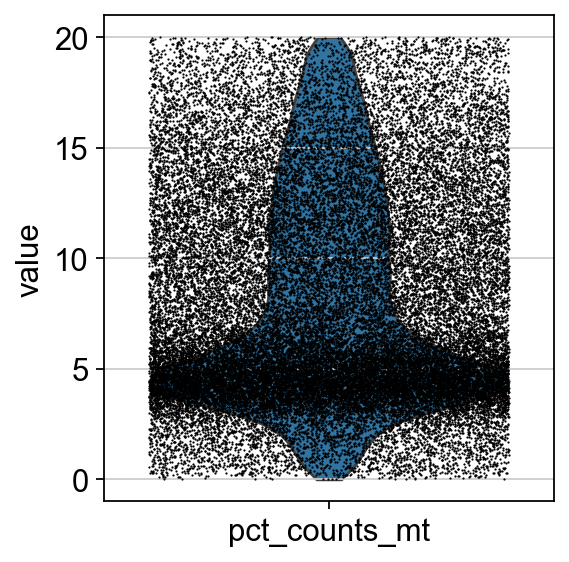

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4)
sc.pl.violin(adata[adata.obs.pct_counts_mt < 20, :], ['pct_counts_mt'], jitter=0.4)

In [7]:
adata = adata[adata.obs.pct_counts_mt < 10, :]

In [8]:
print(len(adata.obs))

27861


Text(0, 0.5, 'UMI Counts')

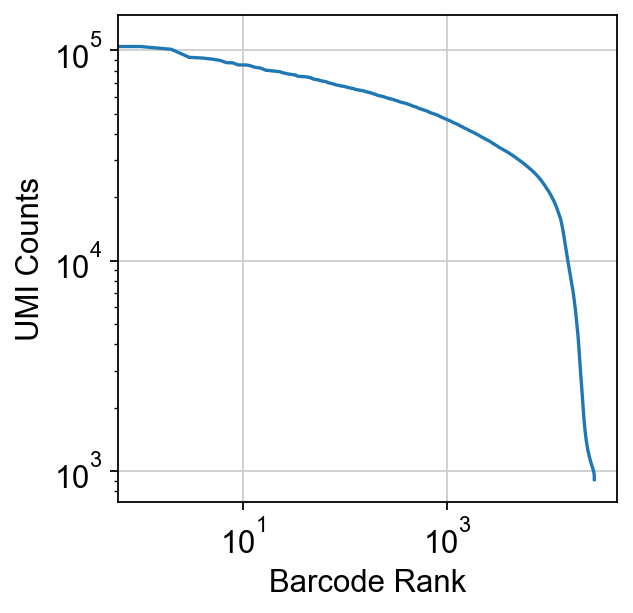

In [9]:
total_counts_list = list(sorted(list(adata.obs['total_counts']), reverse=True))
plt.plot(np.arange(len(total_counts_list)), total_counts_list)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Barcode Rank')
plt.ylabel('UMI Counts')

In [10]:
adata = adata[adata.obs.total_counts > 5000, :]

In [11]:
print(len(adata.obs))

18769


# Processing and Visualization

In [12]:
adata.obs['total_counts_raw'] = adata.obs['total_counts']

C:\Users\pomat\AppData\Local\Temp\ipykernel_25372\2049803437.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['total_counts_raw'] = adata.obs['total_counts']


In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [14]:
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
adata.raw = adata

In [17]:
adata = adata[:, adata.var.highly_variable]

In [18]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [19]:
sc.pp.regress_out(adata, 'total_counts')

regressing out total_counts
    sparse input is densified and may lead to high memory use
    finished (0:00:22)


In [20]:
sc.pp.scale(adata, max_value=10)

In [21]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [22]:
Z = harmonize(adata.obsm['X_pca'], adata.obs, batch_key = 'Batch')
adata.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).


In [23]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_harmony', knn=True)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:05)


In [24]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


In [25]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 55 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [26]:
cluster_nums = []
for i in range(adata.shape[0]):
    cluster_num = int(adata.obs.leiden[i])+1
    cluster_num = str(cluster_num)
    cluster_nums.append(cluster_num)

adata.obs['Cluster'] = pd.Categorical(cluster_nums)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


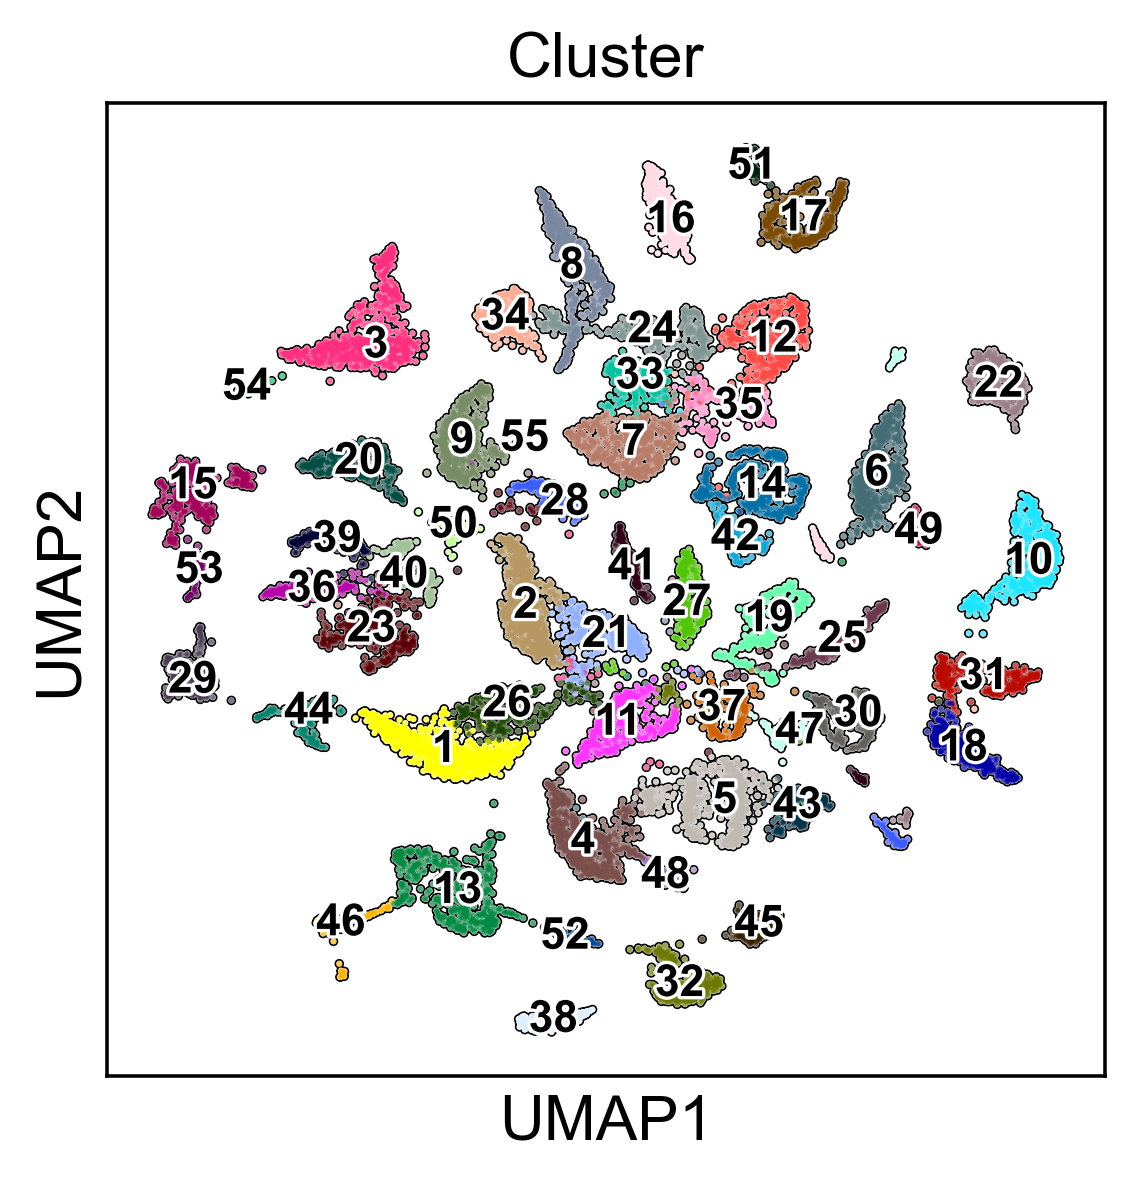

In [27]:
sc.set_figure_params(dpi=160)
sc.pl.umap(adata, color=['Cluster'], add_outline=True, legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


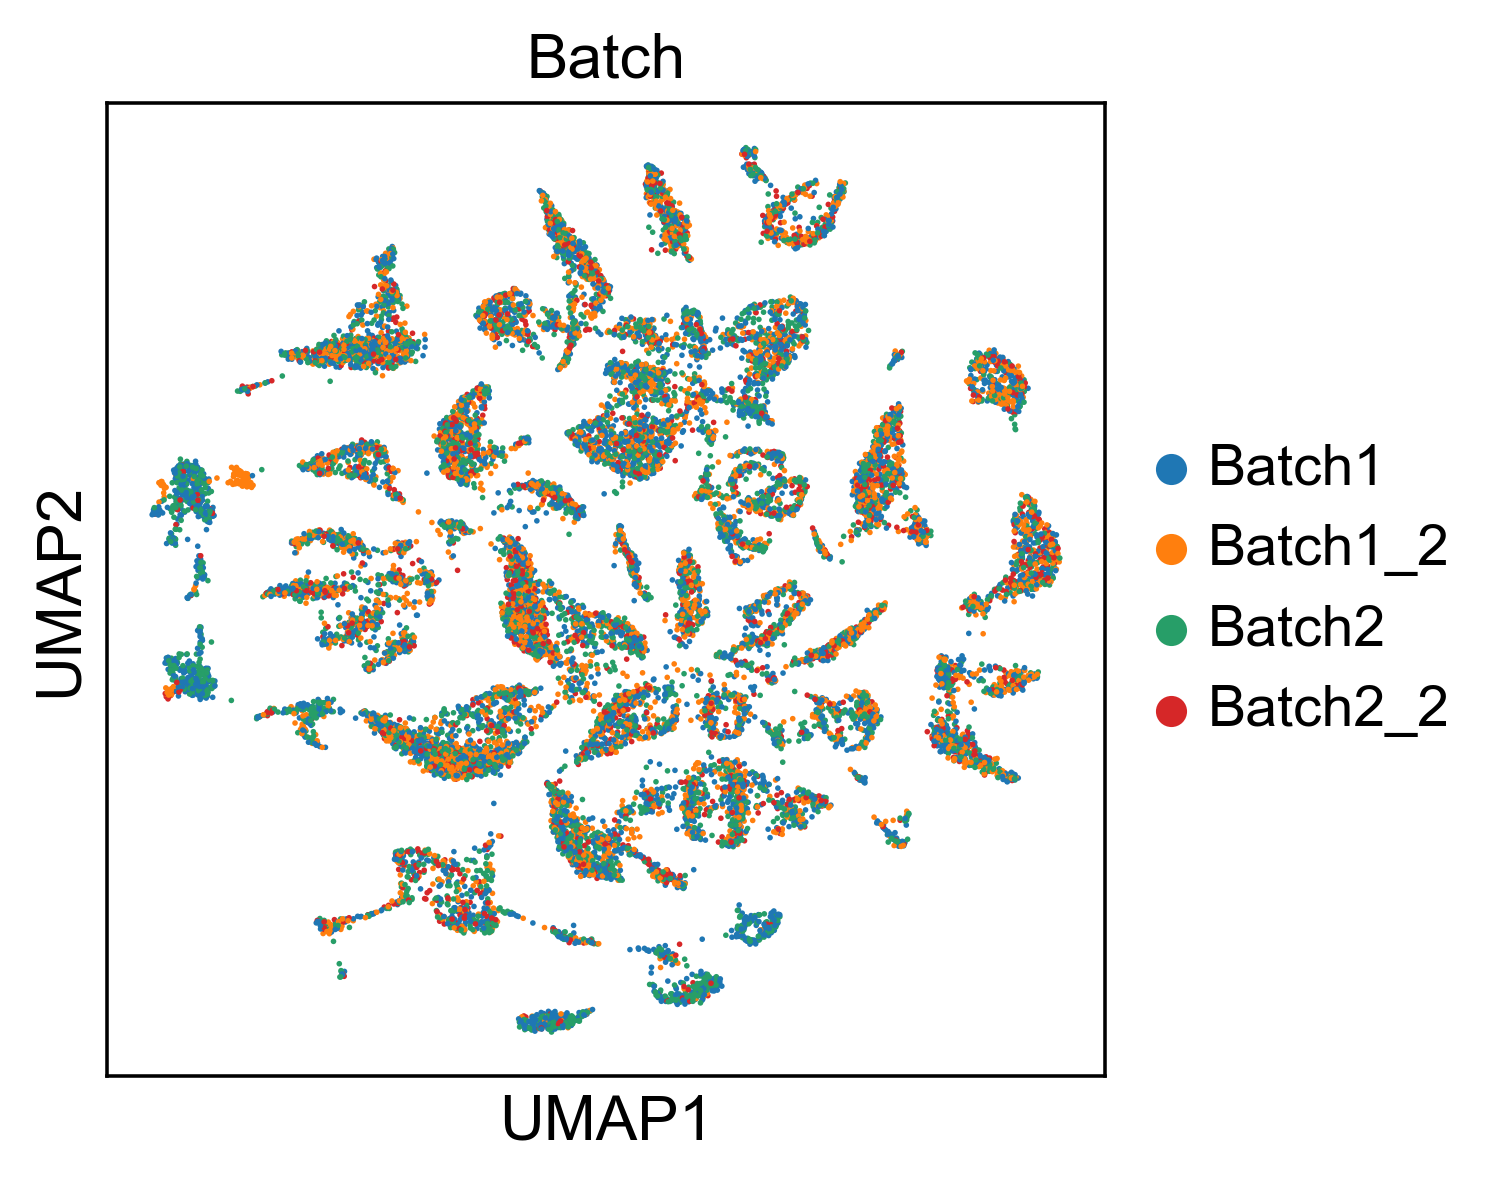

In [28]:
sc.pl.umap(shuffle(adata), color=['Batch'])

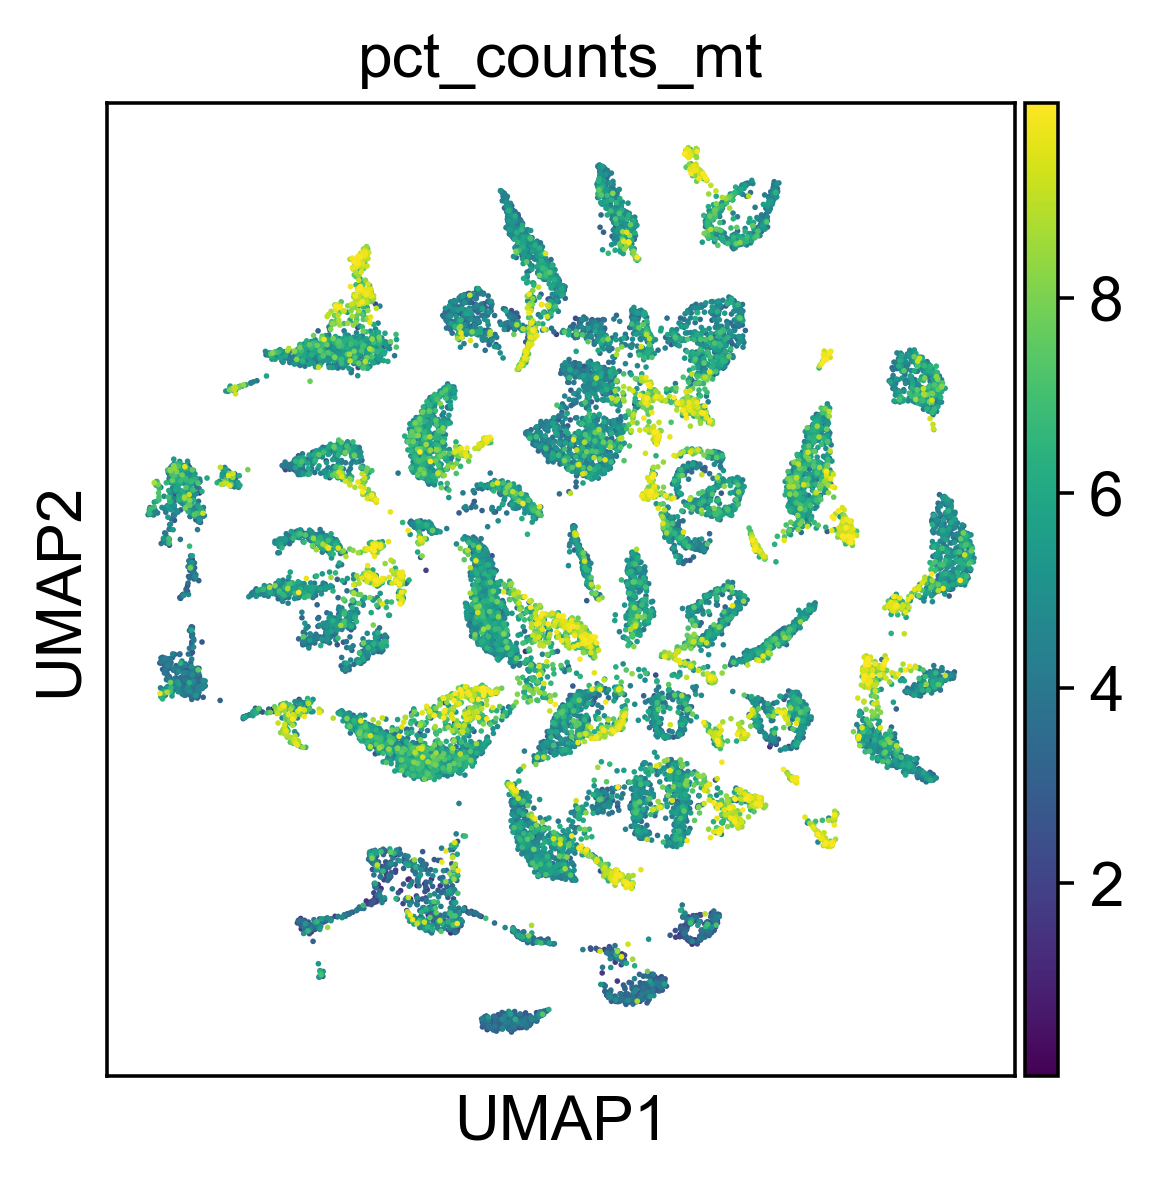

In [29]:
sc.pl.umap(adata, color=['pct_counts_mt'])

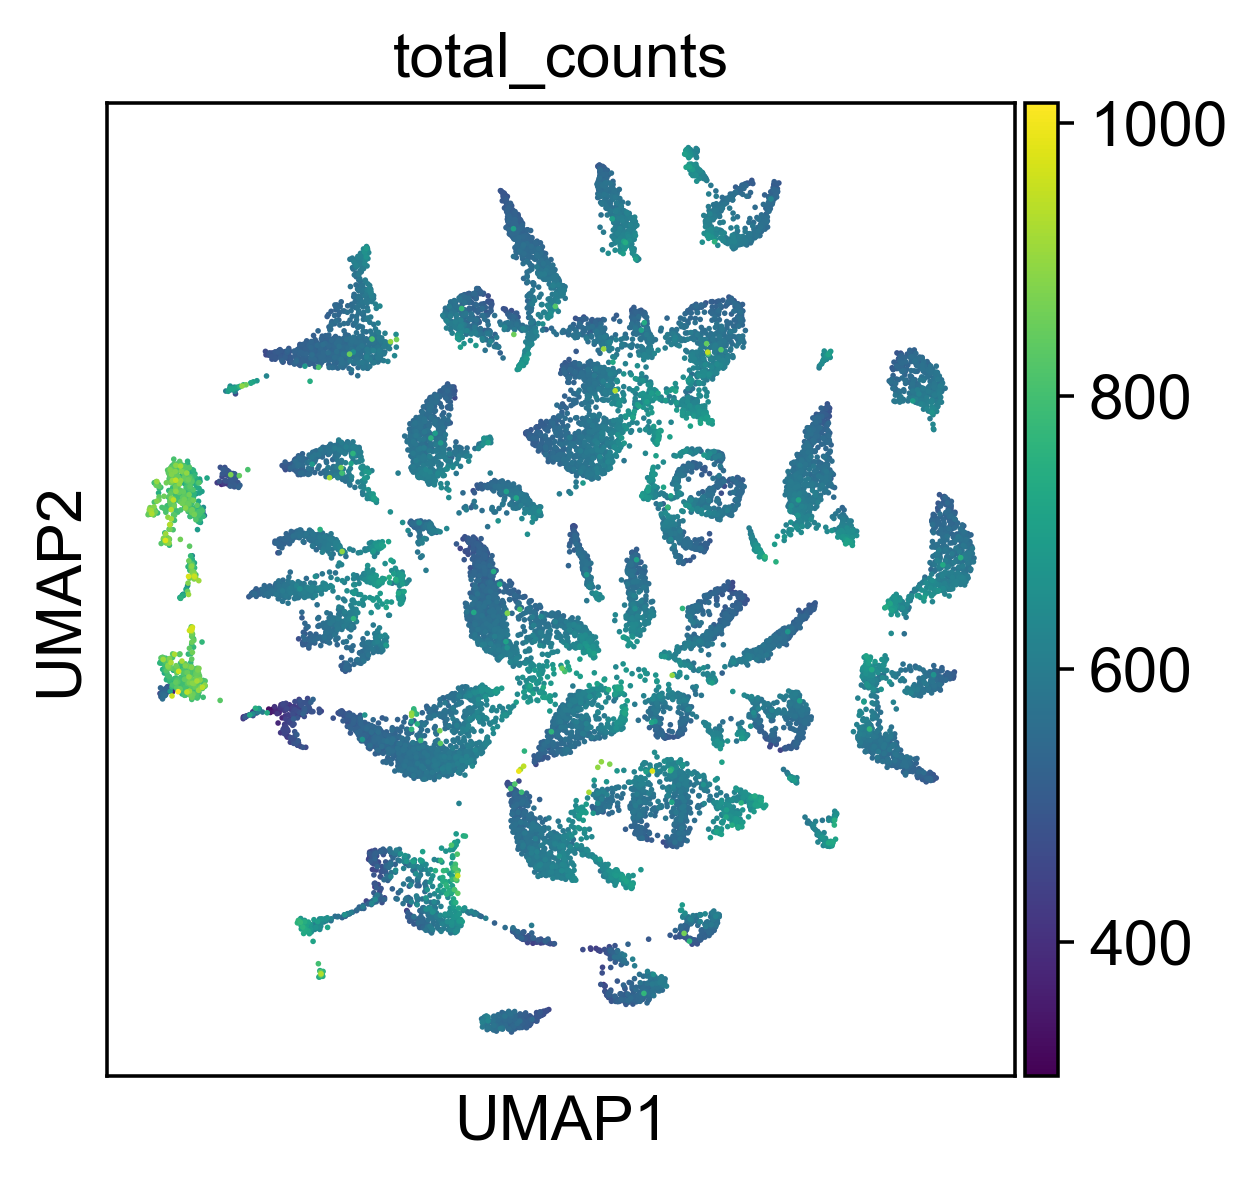

In [30]:
sc.pl.umap(adata, color=['total_counts'])

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


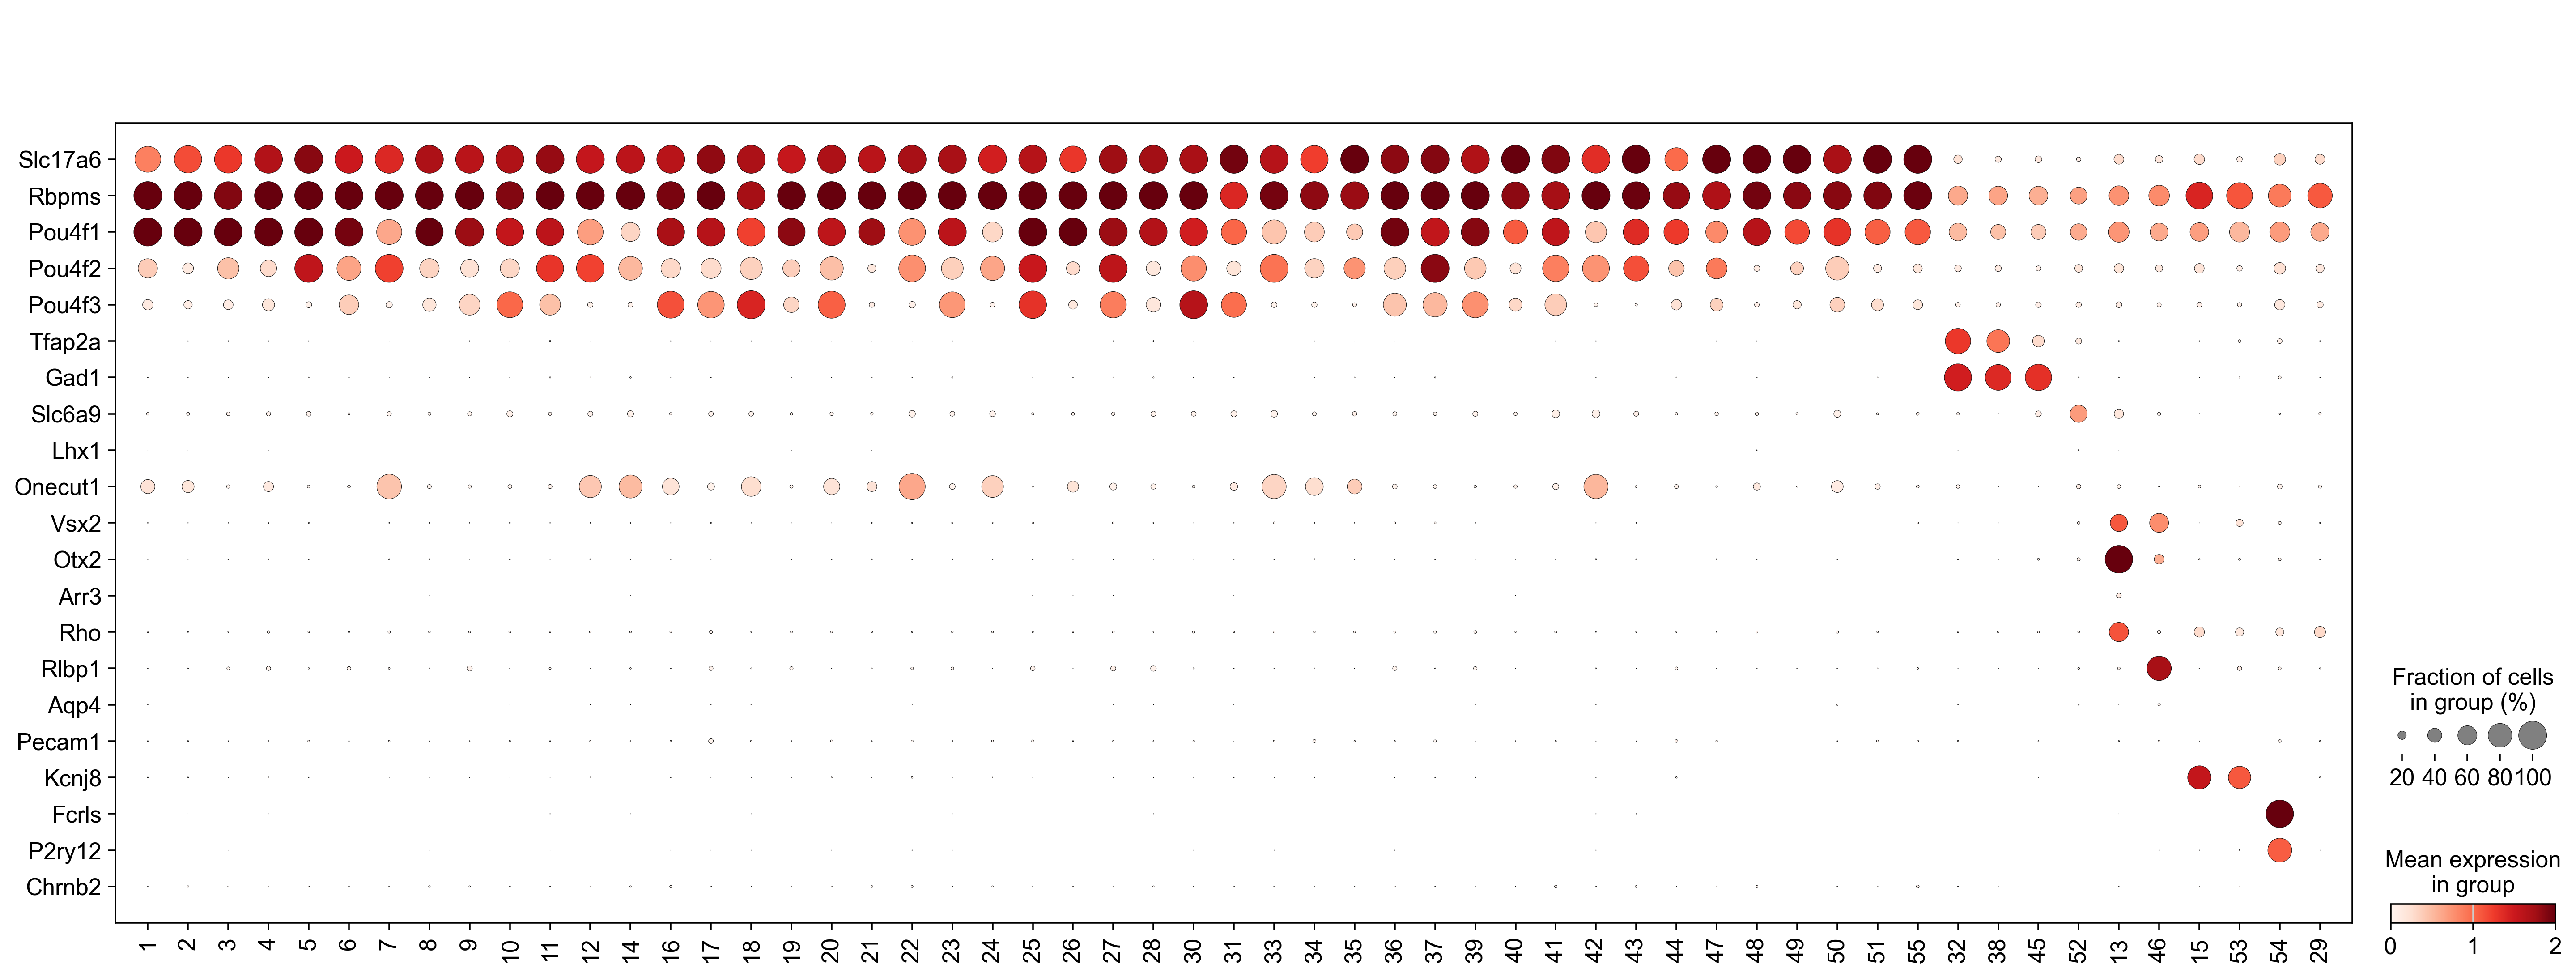

In [34]:
class_markers = ['Slc17a6', 'Rbpms', 'Pou4f1', 'Pou4f2', 'Pou4f3', 'Tfap2a', 'Gad1', 'Slc6a9', 'Lhx1', 'Onecut1', 'Vsx2', 'Otx2', 'Arr3', 'Rho', 'Rlbp1', 'Aqp4', 'Pecam1', 'Kcnj8', 'Fcrls', 'P2ry12', 'Chrnb2']
cluster_order = []
for i in range(len(adata.obs['Cluster'].cat.categories)):
    cluster_order.append(str(i+1))
ending_order = ['32', '38', '45', '52', '13', '46', '15', '53', '54', '29']
for i in ending_order:
    cluster_order.remove(i)
    cluster_order.append(i)
sc.pl.dotplot(adata, var_names=class_markers, groupby='Cluster', swap_axes=True, categories_order=cluster_order, vmax=2, save='P7b2_classes.svg')

In [35]:
adata.write('path/to/adatasP7b2_adata.h5ad')